# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=15,
        fold=4,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-34-47/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191849 [00:00<?, ?it/s]

  0%|          | 0/53439 [00:00<?, ?it/s]

  0%|          | 0/21364 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4849 | MulticlassF1Score=0.1390
Batch-30 : CrossEntropyLoss=2.4744 | MulticlassF1Score=0.2163
Batch-45 : CrossEntropyLoss=2.4269 | MulticlassF1Score=0.2689
Batch-60 : CrossEntropyLoss=2.4723 | MulticlassF1Score=0.2952
Batch-75 : CrossEntropyLoss=2.4057 | MulticlassF1Score=0.3206
Batch-90 : CrossEntropyLoss=2.4229 | MulticlassF1Score=0.3422
Batch-105: CrossEntropyLoss=2.3625 | MulticlassF1Score=0.3687
Batch-120: CrossEntropyLoss=2.3784 | MulticlassF1Score=0.3911
Batch-135: CrossEntropyLoss=2.3659 | MulticlassF1Score=0.4180
Batch-150: CrossEntropyLoss=2.3302 | MulticlassF1Score=0.4453
Batch-165: CrossEntropyLoss=2.3510 | MulticlassF1Score=0.4698
Batch-180: CrossEntropyLoss=2.3491 | MulticlassF1Score=0.4891
Batch-195: CrossEntropyLoss=2.3566 | MulticlassF1Score=0.5060
Batch-210: CrossEntropyLoss=2.3340 | MulticlassF1Score=0.5206
Batch-225: CrossEntropyLoss=2.3315 | MulticlassF1Score=0.5337
Batch-226: CrossEntropyLoss=2.3549 | MulticlassF1Score=0.5343

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3311 | MulticlassF1Score=0.7243
Batch-30 : CrossEntropyLoss=2.3336 | MulticlassF1Score=0.7189
Batch-45 : CrossEntropyLoss=2.3622 | MulticlassF1Score=0.7184
Batch-60 : CrossEntropyLoss=2.3438 | MulticlassF1Score=0.7167
Batch-63 : CrossEntropyLoss=2.3470 | MulticlassF1Score=0.7163

Training   : Mean CrossEntropyLoss = 2.4038 | Mean MulticlassF1Score = 0.3679
Validation : Mean CrossEntropyLoss = 2.3371 | Mean MulticlassF1Score = 0.7194

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3272 | MulticlassF1Score=0.7214
Batch-30 : CrossEntropyLoss=2.3352 | MulticlassF1Score=0.7188
Batch-45 : CrossEntropyLoss=2.3224 | MulticlassF1Score=0.7199
Batch-60 : CrossEntropyLoss=2.3220 | MulticlassF1Score=0.7259
Batch-75 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7326
Batch-90 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7391
Batch-105: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7446
Batch-120: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.7494
Batch-135: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7534
Batch-150: CrossEntropyLoss=2.3187 | MulticlassF1Score=0.7564
Batch-165: CrossEntropyLoss=2.3214 | MulticlassF1Score=0.7590
Batch-180: CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7617
Batch-195: CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7632
Batch-210: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7648
Batch-225: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7665
Batch-226: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7938
Batch-30 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.7860
Batch-45 : CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7880
Batch-60 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.7903
Batch-63 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.7904

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3210 | Mean MulticlassF1Score = 0.7434
Validation : Mean CrossEntropyLoss = 2.3134 | Mean MulticlassF1Score = 0.7907

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7944
Batch-30 : CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7923
Batch-45 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7929
Batch-60 : CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7956
Batch-75 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.7975
Batch-90 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.7985
Batch-105: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.7988
Batch-120: CrossEntropyLoss=2.3042 | MulticlassF1Score=0.7999
Batch-135: CrossEntropyLoss=2.3175 | MulticlassF1Score=0.8006
Batch-150: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8007
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8012
Batch-180: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8021
Batch-195: CrossEntropyLoss=2.3181 | MulticlassF1Score=0.8037
Batch-210: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8050
Batch-225: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8061
Batch-226: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8062

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8186
Batch-30 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8187
Batch-45 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8197
Batch-60 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8210
Batch-63 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8209

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3082 | Mean MulticlassF1Score = 0.7992
Validation : Mean CrossEntropyLoss = 2.3036 | Mean MulticlassF1Score = 0.8193

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8260
Batch-30 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8258
Batch-45 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8260
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8259
Batch-75 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8274
Batch-90 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8276
Batch-105: CrossEntropyLoss=2.3163 | MulticlassF1Score=0.8268
Batch-120: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8260
Batch-135: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8255
Batch-150: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8260
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8262
Batch-180: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8270
Batch-195: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8278
Batch-210: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8285
Batch-225: CrossEntropyLoss=2.3133 | MulticlassF1Score=0.8293
Batch-226: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8293

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8281
Batch-30 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8312
Batch-45 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8320
Batch-60 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8313
Batch-63 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8320

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3007 | Mean MulticlassF1Score = 0.8268
Validation : Mean CrossEntropyLoss = 2.3000 | Mean MulticlassF1Score = 0.8304

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8408
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8382
Batch-45 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8356
Batch-60 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8363
Batch-75 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8371
Batch-90 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8367
Batch-105: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8368
Batch-120: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8379
Batch-135: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8376
Batch-150: CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8367
Batch-165: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8365
Batch-180: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8372
Batch-195: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8370
Batch-210: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8373
Batch-225: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8370
Batch-226: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8371

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8367
Batch-30 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8350
Batch-45 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8331
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8341
Batch-63 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8335

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8374
Validation : Mean CrossEntropyLoss = 2.2995 | Mean MulticlassF1Score = 0.8347

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8363
Batch-30 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8371
Batch-45 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8375
Batch-60 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8362
Batch-75 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8366
Batch-90 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8372
Batch-105: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8378
Batch-120: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8387
Batch-135: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8391
Batch-150: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8397
Batch-165: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8399
Batch-180: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8394
Batch-195: CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8393
Batch-210: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8391
Batch-225: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8395
Batch-226: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8311
Batch-30 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8365
Batch-45 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8363
Batch-60 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8364
Batch-63 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8348

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2975 | Mean MulticlassF1Score = 0.8381
Validation : Mean CrossEntropyLoss = 2.2990 | Mean MulticlassF1Score = 0.8353

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8363
Batch-30 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8392
Batch-45 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8416
Batch-60 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.8399
Batch-75 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8395
Batch-90 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8395
Batch-105: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8393
Batch-120: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8392
Batch-135: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8395
Batch-150: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8397
Batch-165: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8401
Batch-180: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8406
Batch-195: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8411
Batch-210: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8411
Batch-225: CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8411
Batch-226: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8410

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8315
Batch-30 : CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8326
Batch-45 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8329
Batch-60 : CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8358
Batch-63 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2969 | Mean MulticlassF1Score = 0.8395
Validation : Mean CrossEntropyLoss = 2.2985 | Mean MulticlassF1Score = 0.8329

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8447
Batch-30 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8444
Batch-45 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8434
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8429
Batch-75 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8426
Batch-90 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8432
Batch-105: CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8439
Batch-120: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8430
Batch-135: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8427
Batch-150: CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8425
Batch-165: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8423
Batch-180: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8433
Batch-195: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8442
Batch-210: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8457
Batch-225: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8470
Batch-226: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8585
Batch-30 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8594
Batch-45 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8600
Batch-60 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8617
Batch-63 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8620

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2951 | Mean MulticlassF1Score = 0.8439
Validation : Mean CrossEntropyLoss = 2.2911 | Mean MulticlassF1Score = 0.8581

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8703
Batch-30 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8713
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8691
Batch-60 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8700
Batch-75 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8704
Batch-90 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8709
Batch-105: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8717
Batch-120: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8724
Batch-135: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8728
Batch-150: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8728
Batch-165: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8724
Batch-180: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8724
Batch-195: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8718
Batch-210: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8716
Batch-225: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8717
Batch-226: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8718

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8675
Batch-30 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8653
Batch-45 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8681
Batch-60 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8665
Batch-63 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8668

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2876 | Mean MulticlassF1Score = 0.8712
Validation : Mean CrossEntropyLoss = 2.2891 | Mean MulticlassF1Score = 0.8673

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8751
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8733
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8739
Batch-60 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8736
Batch-75 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8731
Batch-90 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8734
Batch-105: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8762
Batch-120: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8781
Batch-135: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8799
Batch-150: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8808
Batch-165: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8812
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8822
Batch-195: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8833
Batch-210: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8833
Batch-225: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8835
Batch-226: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8835

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8805
Batch-30 : CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8841
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8826
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8838
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8845

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8782
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8813

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8914
Batch-30 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8922
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8922
Batch-60 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8939
Batch-75 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8936
Batch-90 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8944
Batch-105: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8937
Batch-120: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8939
Batch-135: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8941
Batch-150: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8938
Batch-165: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8935
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8933
Batch-195: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8930
Batch-210: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8929
Batch-225: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8925
Batch-226: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8925

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8823
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8825
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8835
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8839
Batch-63 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8835

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8932
Validation : Mean CrossEntropyLoss = 2.2841 | Mean MulticlassF1Score = 0.8827

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8948
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8949
Batch-45 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8936
Batch-60 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8933
Batch-75 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.8937
Batch-90 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8945
Batch-105: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8938
Batch-120: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8936
Batch-135: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8939
Batch-150: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8944
Batch-165: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8943
Batch-180: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8945
Batch-195: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8951
Batch-210: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8951
Batch-225: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8949
Batch-226: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8949

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8847
Batch-30 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8836
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8840
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8846
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8850

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8940
Validation : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8832

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8964
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8972
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8972
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8952
Batch-90 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8957
Batch-105: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.8958
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8962
Batch-135: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8962
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8969
Batch-165: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8970
Batch-180: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8970
Batch-195: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8971
Batch-210: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8970
Batch-225: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8966
Batch-226: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8965

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8825
Batch-30 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8832
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8856
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8869
Batch-63 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8864

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2798 | Mean MulticlassF1Score = 0.8969
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8834

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.8998
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9002
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8987
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9001
Batch-75 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8993
Batch-90 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8987
Batch-105: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8982
Batch-120: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8981
Batch-135: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8975
Batch-150: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8975
Batch-165: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8976
Batch-180: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8978
Batch-195: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8976
Batch-210: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8979
Batch-225: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8980
Batch-226: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8980

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8855
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8842
Batch-45 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8854
Batch-60 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8859
Batch-63 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8861

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2792 | Mean MulticlassF1Score = 0.8984
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8845

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8947
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8970
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8982
Batch-60 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8996
Batch-75 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8989
Batch-90 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8987
Batch-105: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8982
Batch-120: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8984
Batch-135: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8985
Batch-150: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8991
Batch-165: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8991
Batch-180: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8987
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8990
Batch-210: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8990
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8987
Batch-226: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8988

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8826
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8876
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8863

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.8982
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8858

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9018
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9011
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9021
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9015
Batch-75 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9004
Batch-90 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9000
Batch-105: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9009
Batch-120: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9007
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9008
Batch-150: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9010
Batch-165: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9006
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.9002
Batch-195: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8999
Batch-210: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8999
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8997
Batch-226: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8997

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8853
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8867
Batch-45 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8877
Batch-60 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8862
Batch-63 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8861

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.9008
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8862

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9035
Batch-30 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.9013
Batch-45 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8995
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9005
Batch-75 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9004
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9015
Batch-105: CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9015
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9011
Batch-135: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9009
Batch-150: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9007
Batch-165: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9007
Batch-180: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9009
Batch-195: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9006
Batch-210: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9005
Batch-225: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.9004
Batch-226: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9005

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8868
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8853
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8855
Batch-60 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8862
Batch-63 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8864

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9012
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8861

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8973
Batch-30 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8984
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9000
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9000
Batch-75 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9004
Batch-90 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9013
Batch-105: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9011
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9012
Batch-135: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9007
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9010
Batch-165: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9013
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9011
Batch-195: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9010
Batch-210: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9012
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9013
Batch-226: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9013

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8861
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8858
Batch-45 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8849
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8865
Batch-63 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8874

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2781 | Mean MulticlassF1Score = 0.9002
Validation : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8875

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9036
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9039
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9054
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9055
Batch-75 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9054
Batch-90 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9052
Batch-105: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9042
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9038
Batch-135: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9040
Batch-150: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9048
Batch-165: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9050
Batch-180: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9051
Batch-195: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9050
Batch-210: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9050
Batch-225: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9048
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9048

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8930
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8931
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.8918
Batch-60 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8930
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8928

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2770 | Mean MulticlassF1Score = 0.9050
Validation : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8932

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9060
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9066
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9074
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9076
Batch-75 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9076
Batch-90 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9080
Batch-105: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9073
Batch-120: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9072
Batch-135: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9075
Batch-150: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9070
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9071
Batch-180: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9072
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9073
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9073
Batch-225: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9086
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9086

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9149
Batch-30 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9163
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9182
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9170
Batch-63 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9161

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9072
Validation : Mean CrossEntropyLoss = 2.2740 | Mean MulticlassF1Score = 0.9170

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9332
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9329
Batch-45 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9330
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9331
Batch-90 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9328
Batch-105: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9330
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9327
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9328
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9332
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9335
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9339
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9340
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9342
Batch-225: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9344
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9344

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9171
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9193
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9198
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9211

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2681 | Mean MulticlassF1Score = 0.9334
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9204

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9348
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9390
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9380
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9382
Batch-120: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9384
Batch-135: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9382
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9380
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9378
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9379
Batch-210: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9379
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9379

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9228
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9235
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9237

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9372
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9370
Batch-45 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9397
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9390
Batch-75 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9385
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9387
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9386
Batch-135: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9393
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9396
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9393
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9391
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9392
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9242

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9256

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9403
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9418
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9425
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9425
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9428
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9430
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9428
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9430
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9430
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9425
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9425

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9254
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9258

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9418
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9252

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9441
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9446
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9442
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9440
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9442
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9255

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9387
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9448
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9452
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9448
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9444
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9443
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9444
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9443
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9443
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9443
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9236

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9451
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9458
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9455
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9445
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9449
Batch-226: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9449

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9291
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9288
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9449
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9283

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9462
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9440
Batch-90 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9440
Batch-105: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9446
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9446
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9444
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9449
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9265

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9444
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9239
Patience = 1/50❗

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9461
Batch-75 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9456
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9455
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9453
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9452
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9271

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9505
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9463
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9455
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9457
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9455
Batch-180: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9456
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9457
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9251

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9461
Batch-135: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9457
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9458
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9459
Batch-226: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9459

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9304
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9287

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9504
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9470
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9463
Batch-210: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9461
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9268
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9272
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9277
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9273

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9470
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9467
Batch-105: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9470
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9468
Batch-195: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9465
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9265
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9282

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9473
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9276

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9464
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9466
Batch-75 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9467
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9465
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9467
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9468
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9467
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9466
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9281
Batch-63 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9468
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9262

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9467
Batch-90 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9472
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9468
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9472
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9473
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9470
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9299
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9290
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9284
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9466
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9294

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9465
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9469
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9469
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9475
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9477
Batch-225: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9305
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9289
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9293
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9294

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9460
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9465
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9462
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9460
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9470
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9472
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9476
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9476

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9296
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9297

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9497
Batch-75 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9486
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9488
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9488
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9484
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9481
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9482
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9479
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9477
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9473
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9275

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9481
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9258
Patience = 2/50❗

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9385
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9428
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9437
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9439
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9443
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9484
Batch-226: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9484

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9493

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9662
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9666
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9657
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9657
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9661
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9665
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9663
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9663
Batch-165: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9663
Batch-210: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9483

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9670
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9480

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9700
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9693
Batch-75 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9689
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9693
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9479

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9482

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9680
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9680
Batch-60 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9509
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9502

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9487

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9484
Patience = 3/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9682
Batch-75 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9686
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9508
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9476

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9490
Patience = 4/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9696
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9693
Batch-90 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9468
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9717
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9701
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9690
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9690
Batch-195: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9531
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9501
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9503

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9684
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9694
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9517
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9492

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9675
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9690
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9480

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9486

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2569
Best CrossEntropyLoss training    : 2.2636
Best MulticlassF1Score validation : 0.9689
Best MulticlassF1Score validation : 0.9486
Training duration                 : 2.7884 minutes.
Training date                     : 2022-10-19 14:11:24.838596+08:00


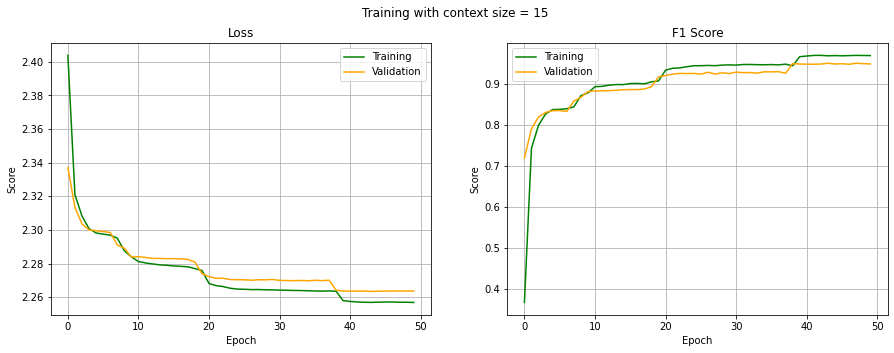

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9698, device='cuda:0'),
 tensor(0.9480, device='cuda:0'),
 tensor(0.9487, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9698, device='cuda:0'),
 tensor(0.9480, device='cuda:0'),
 tensor(0.9487, device='cuda:0'))

## Heatmap

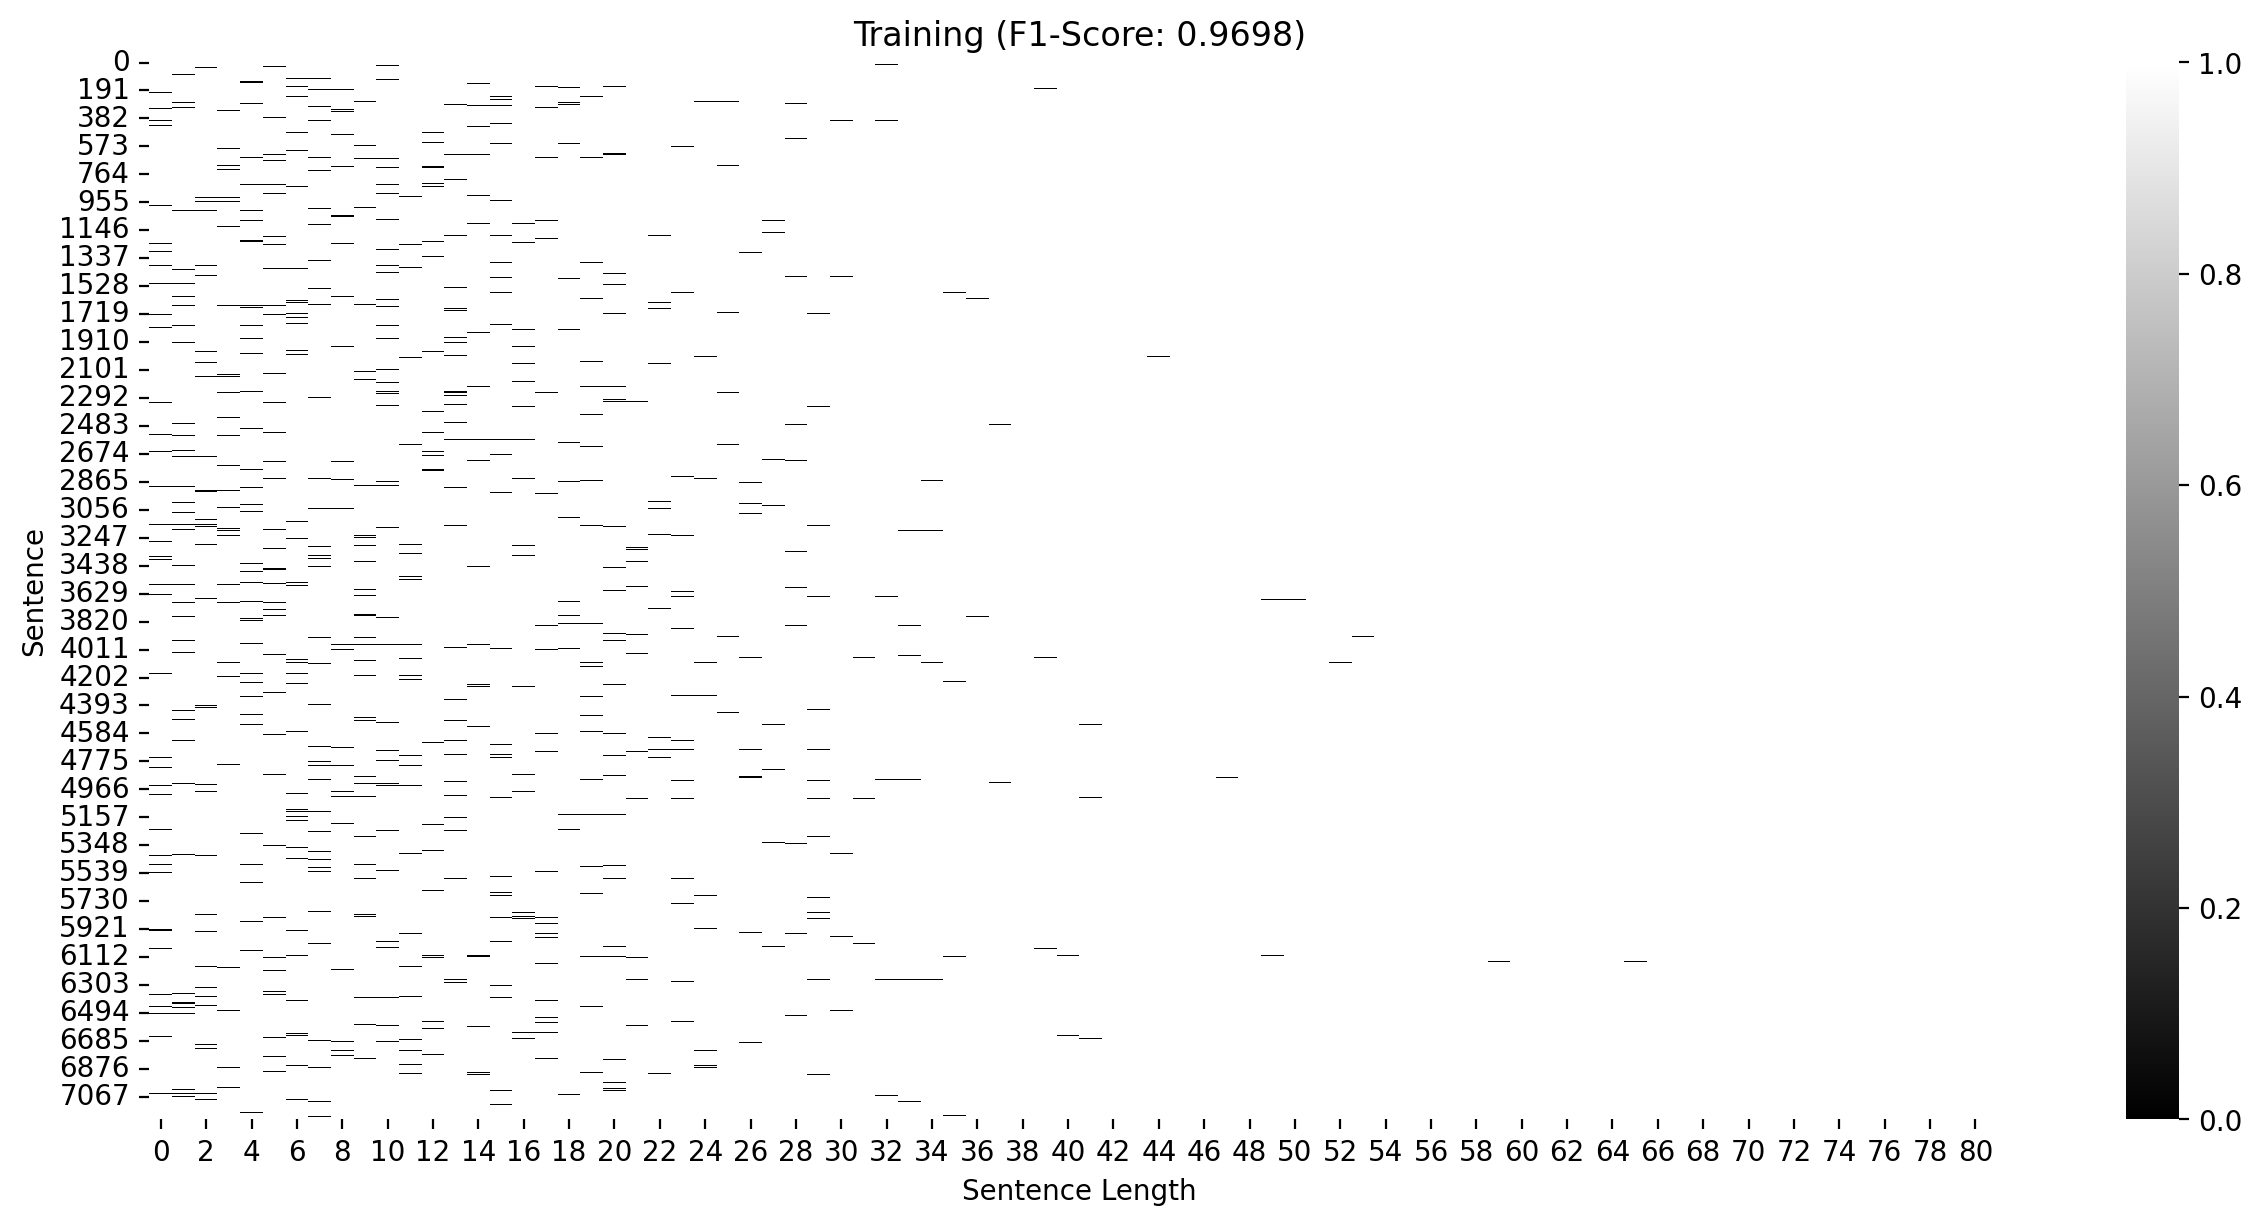

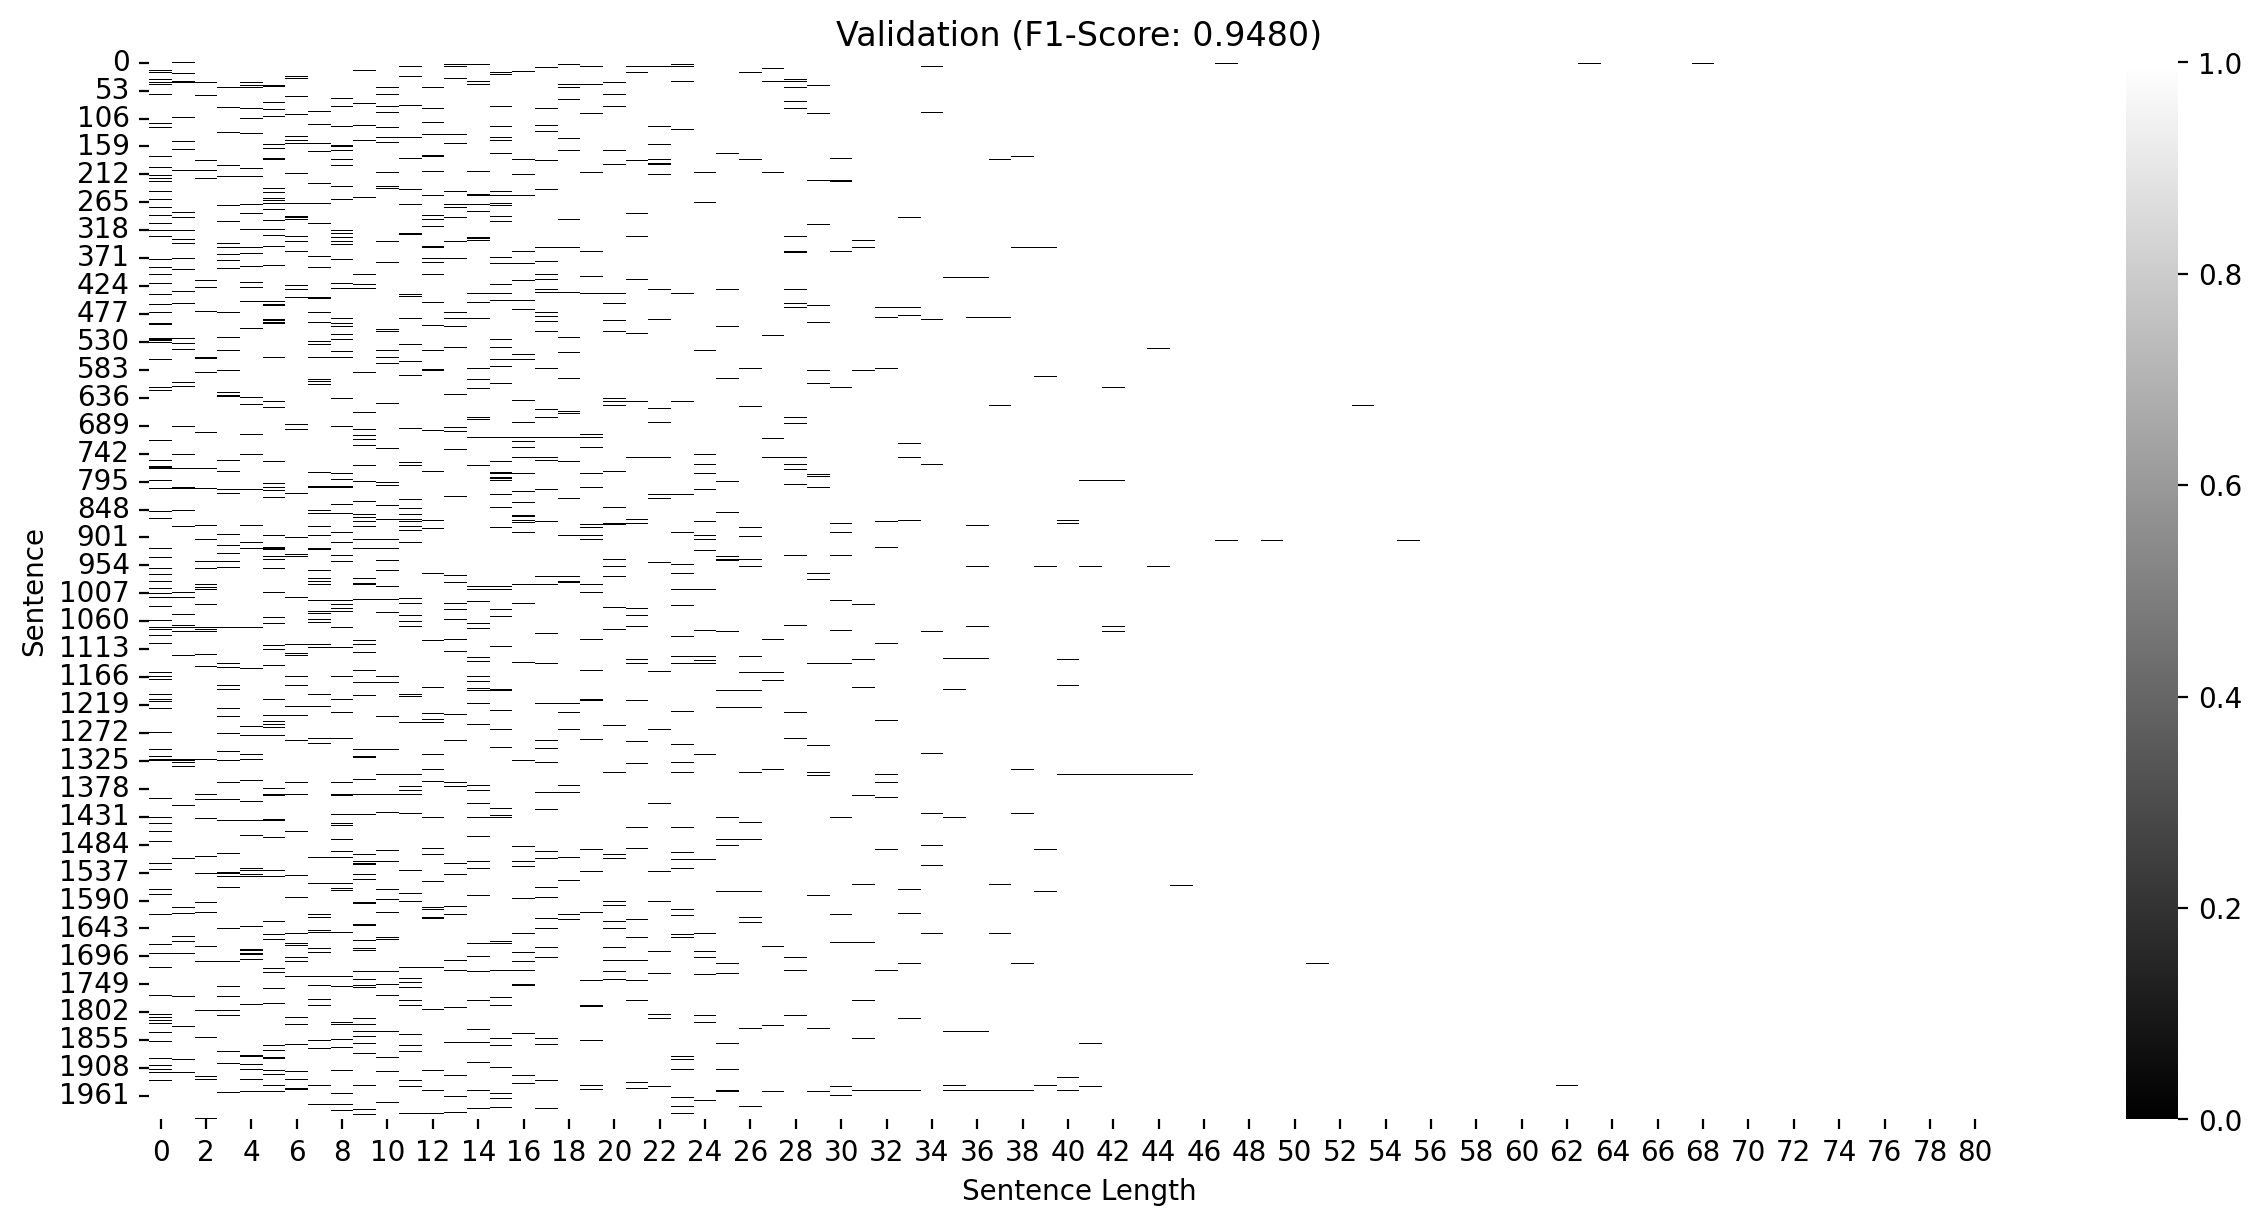

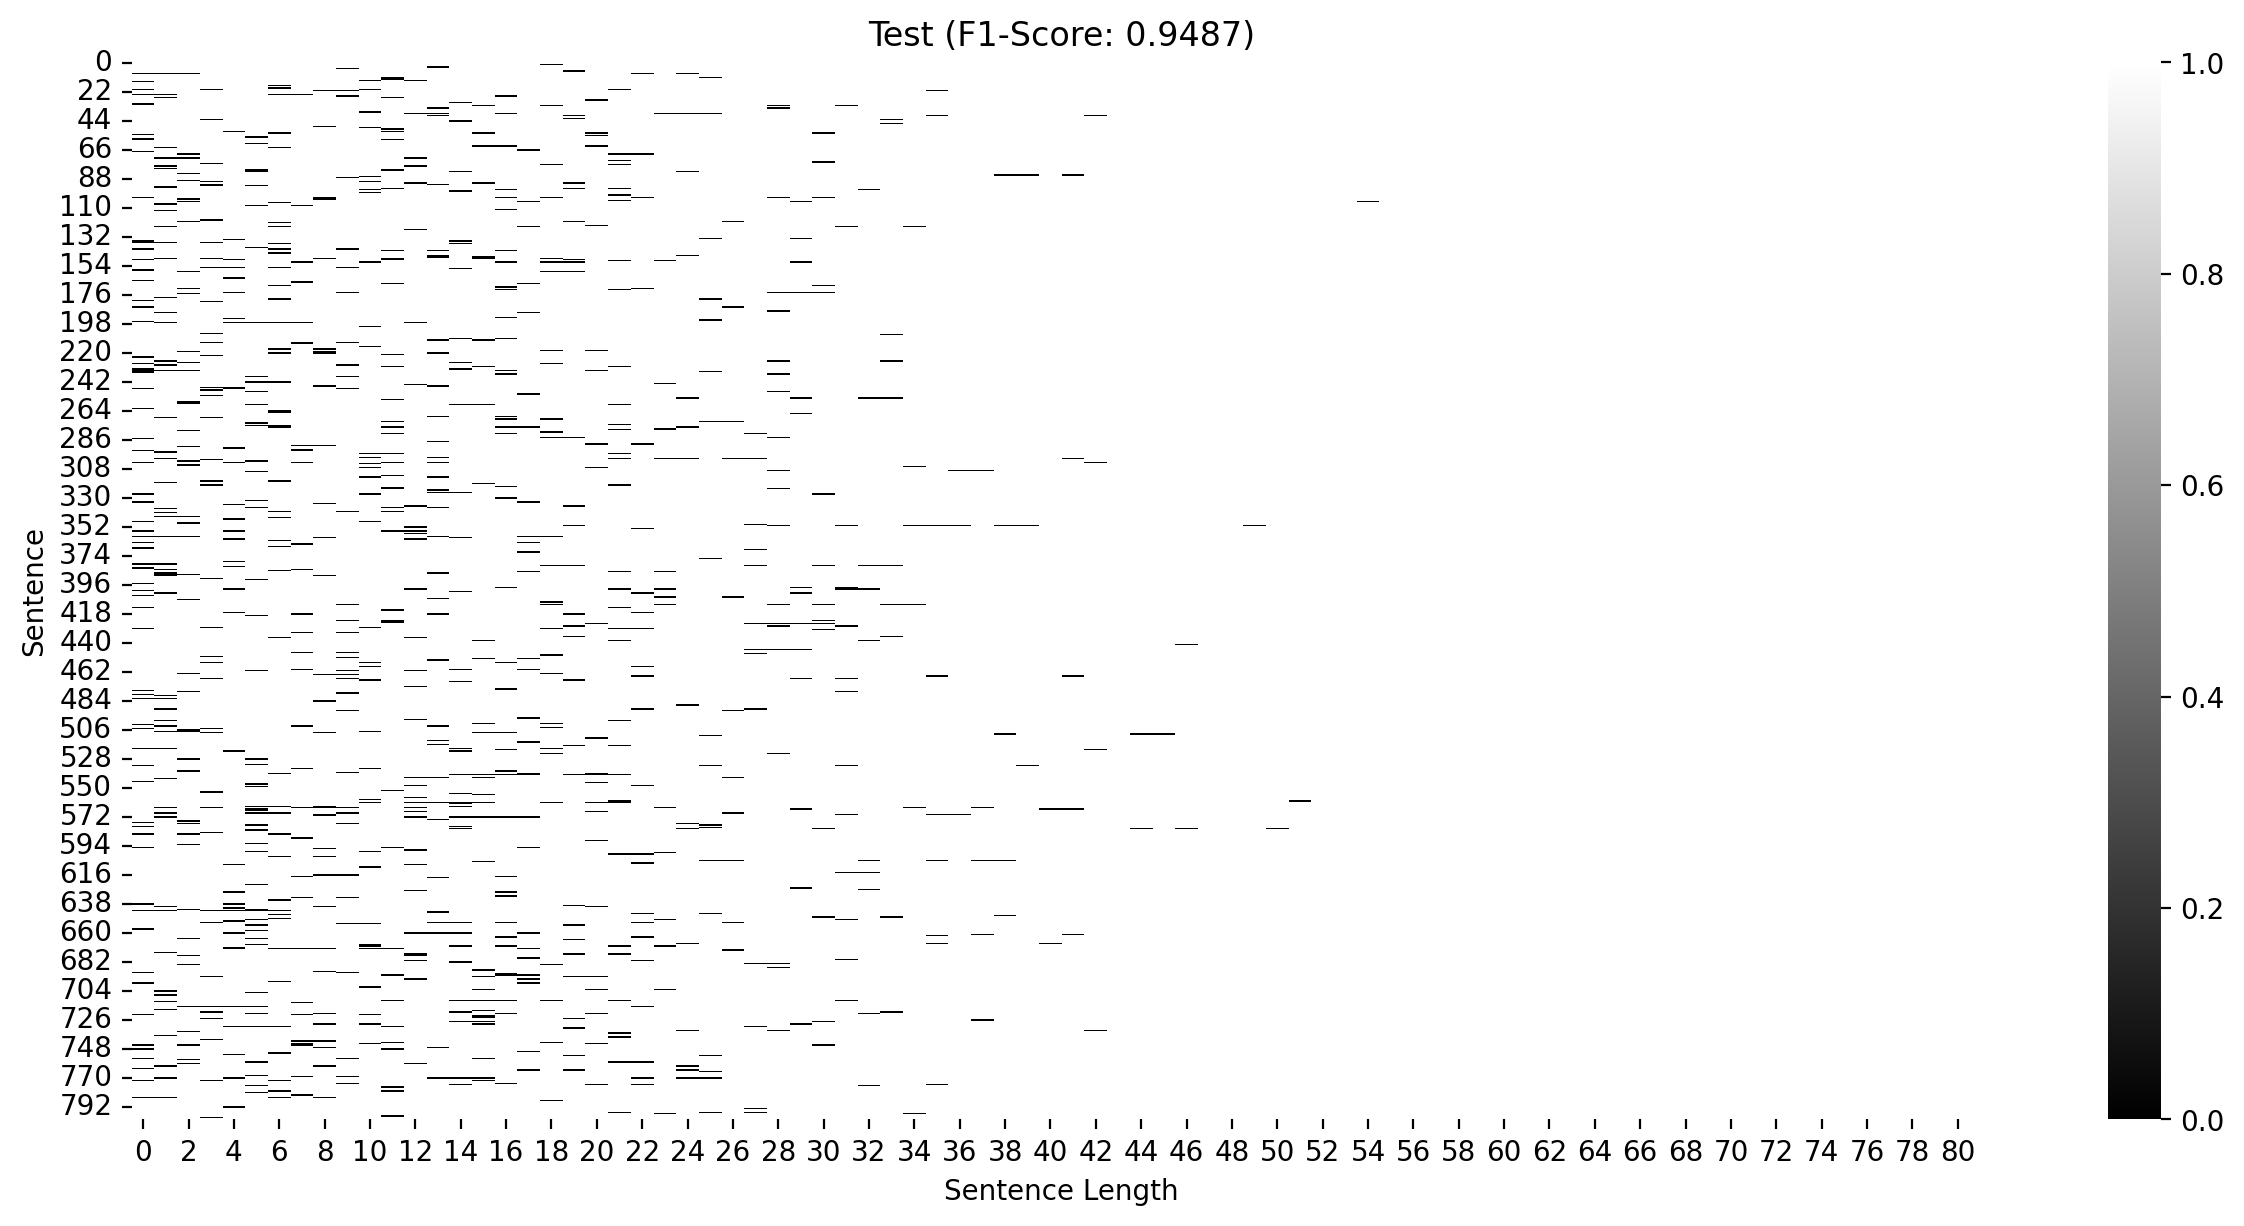

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


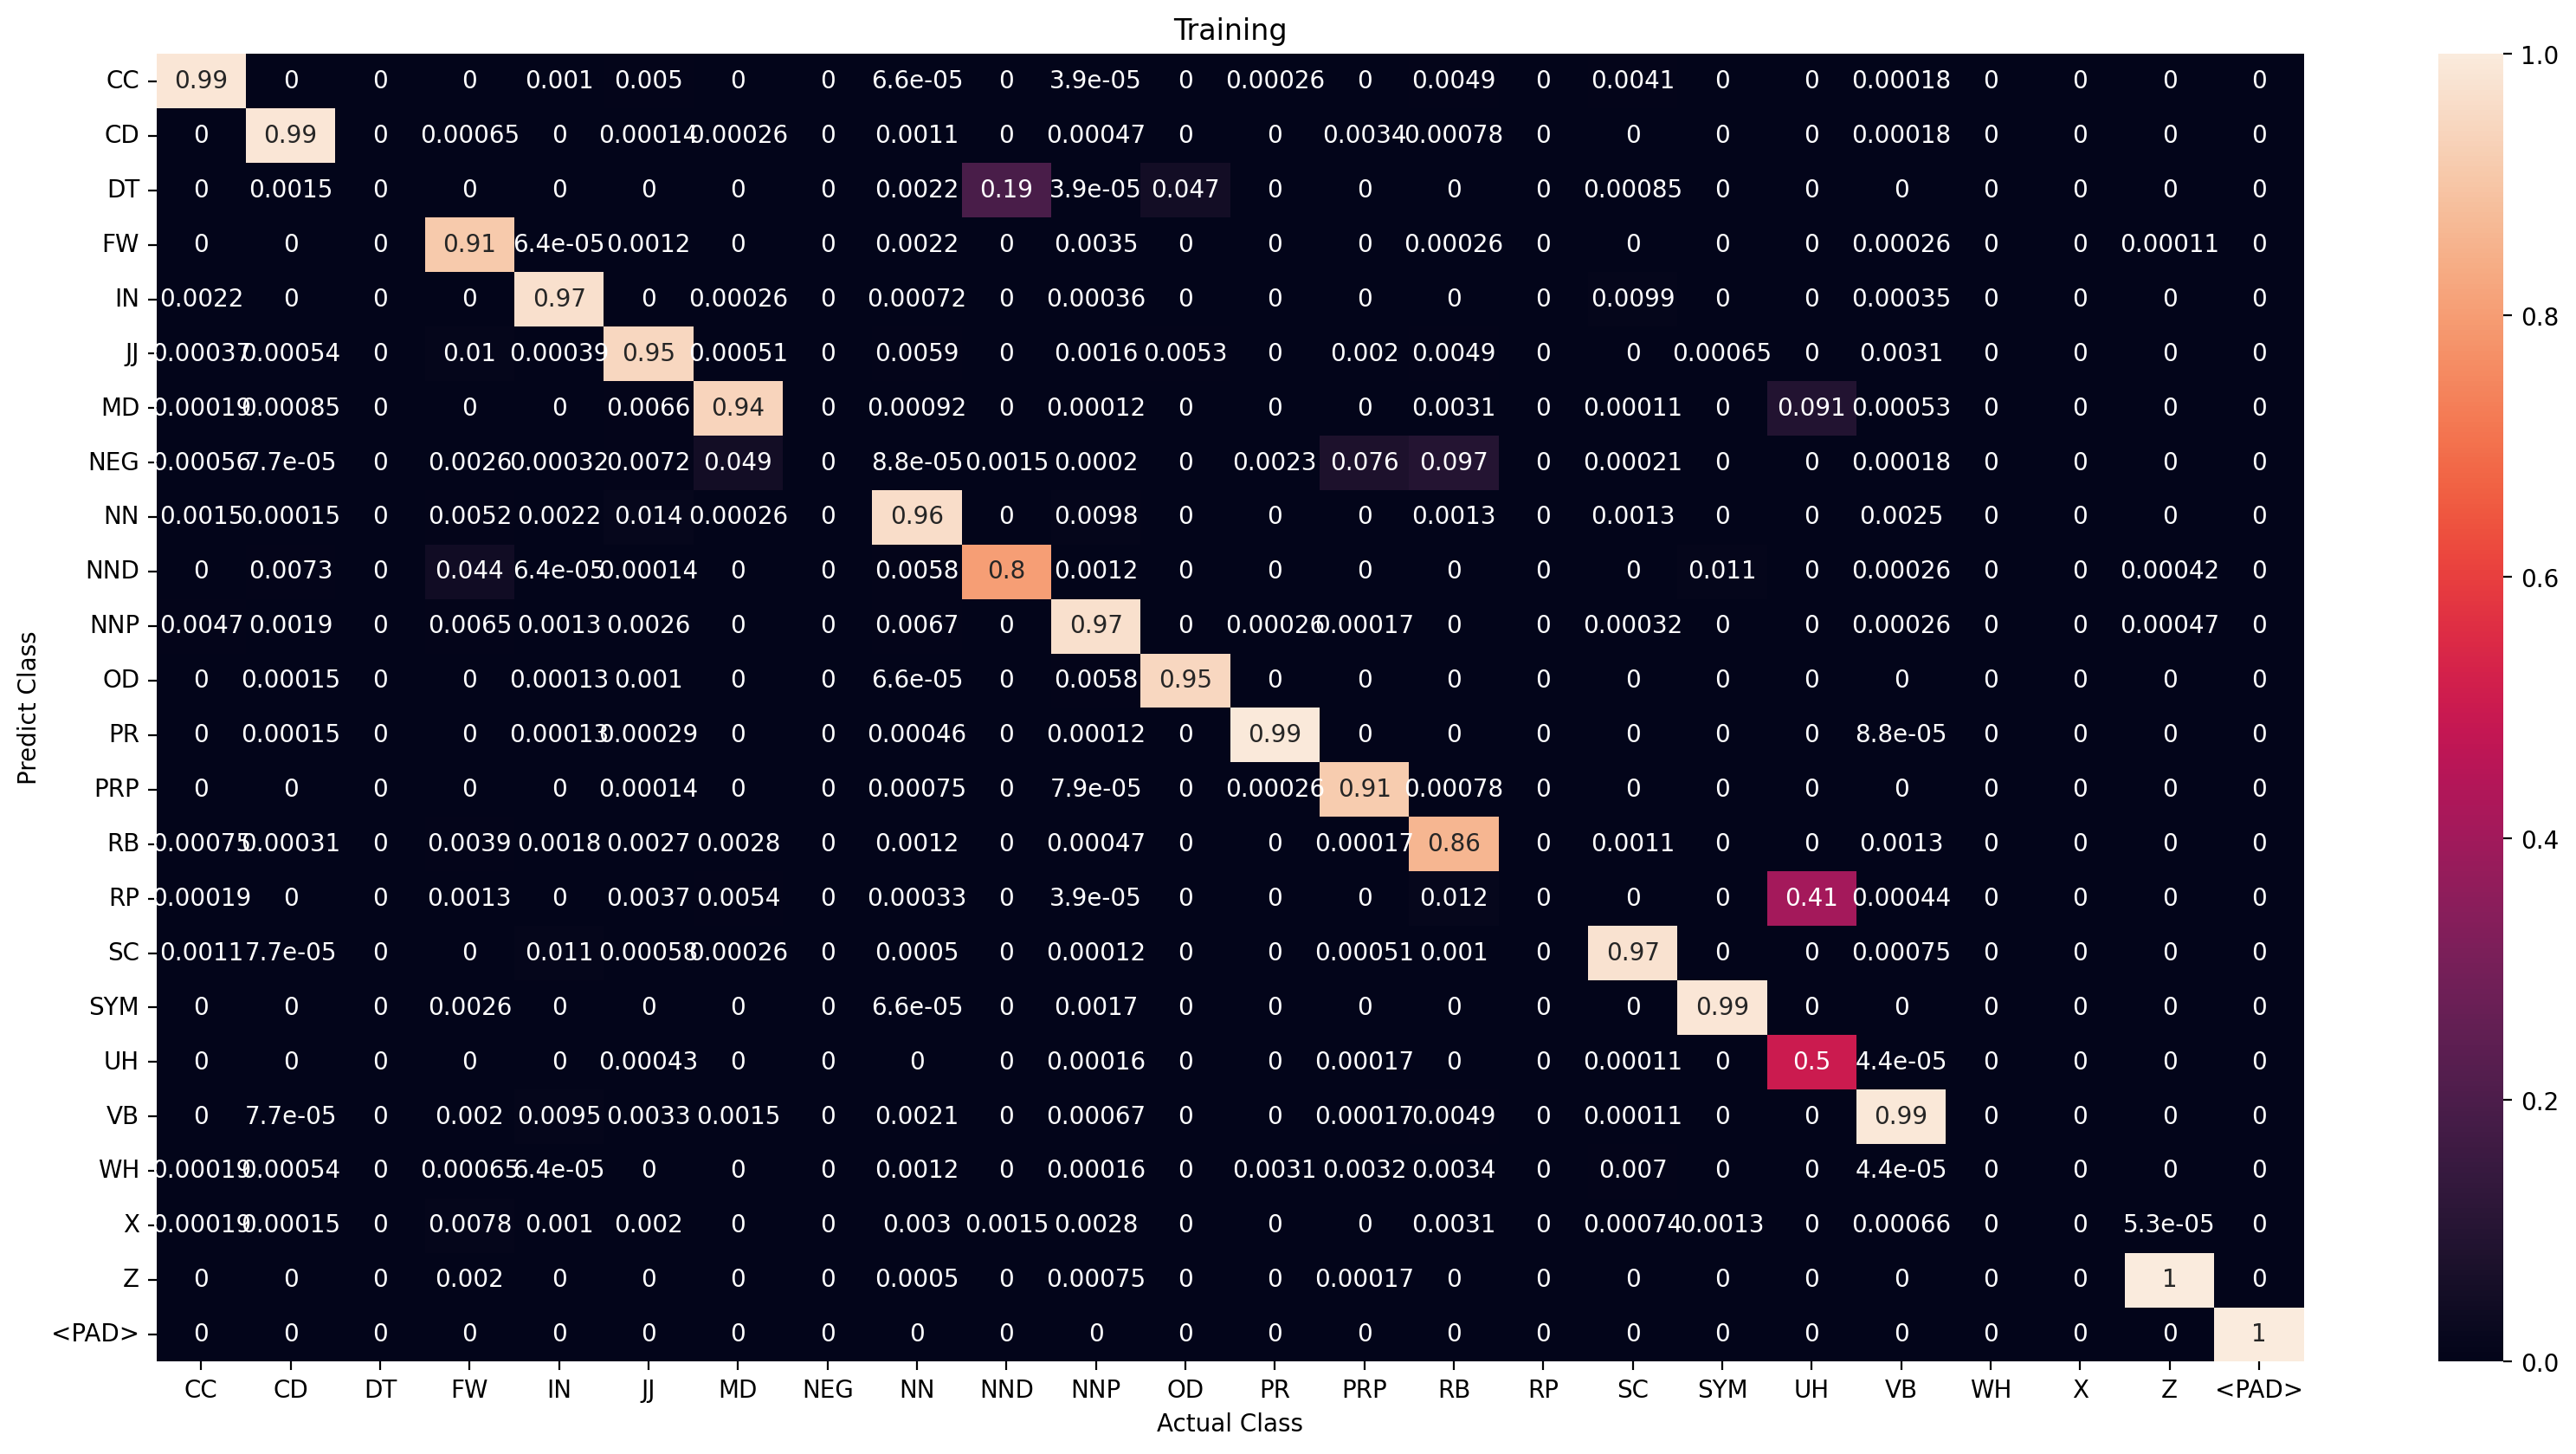

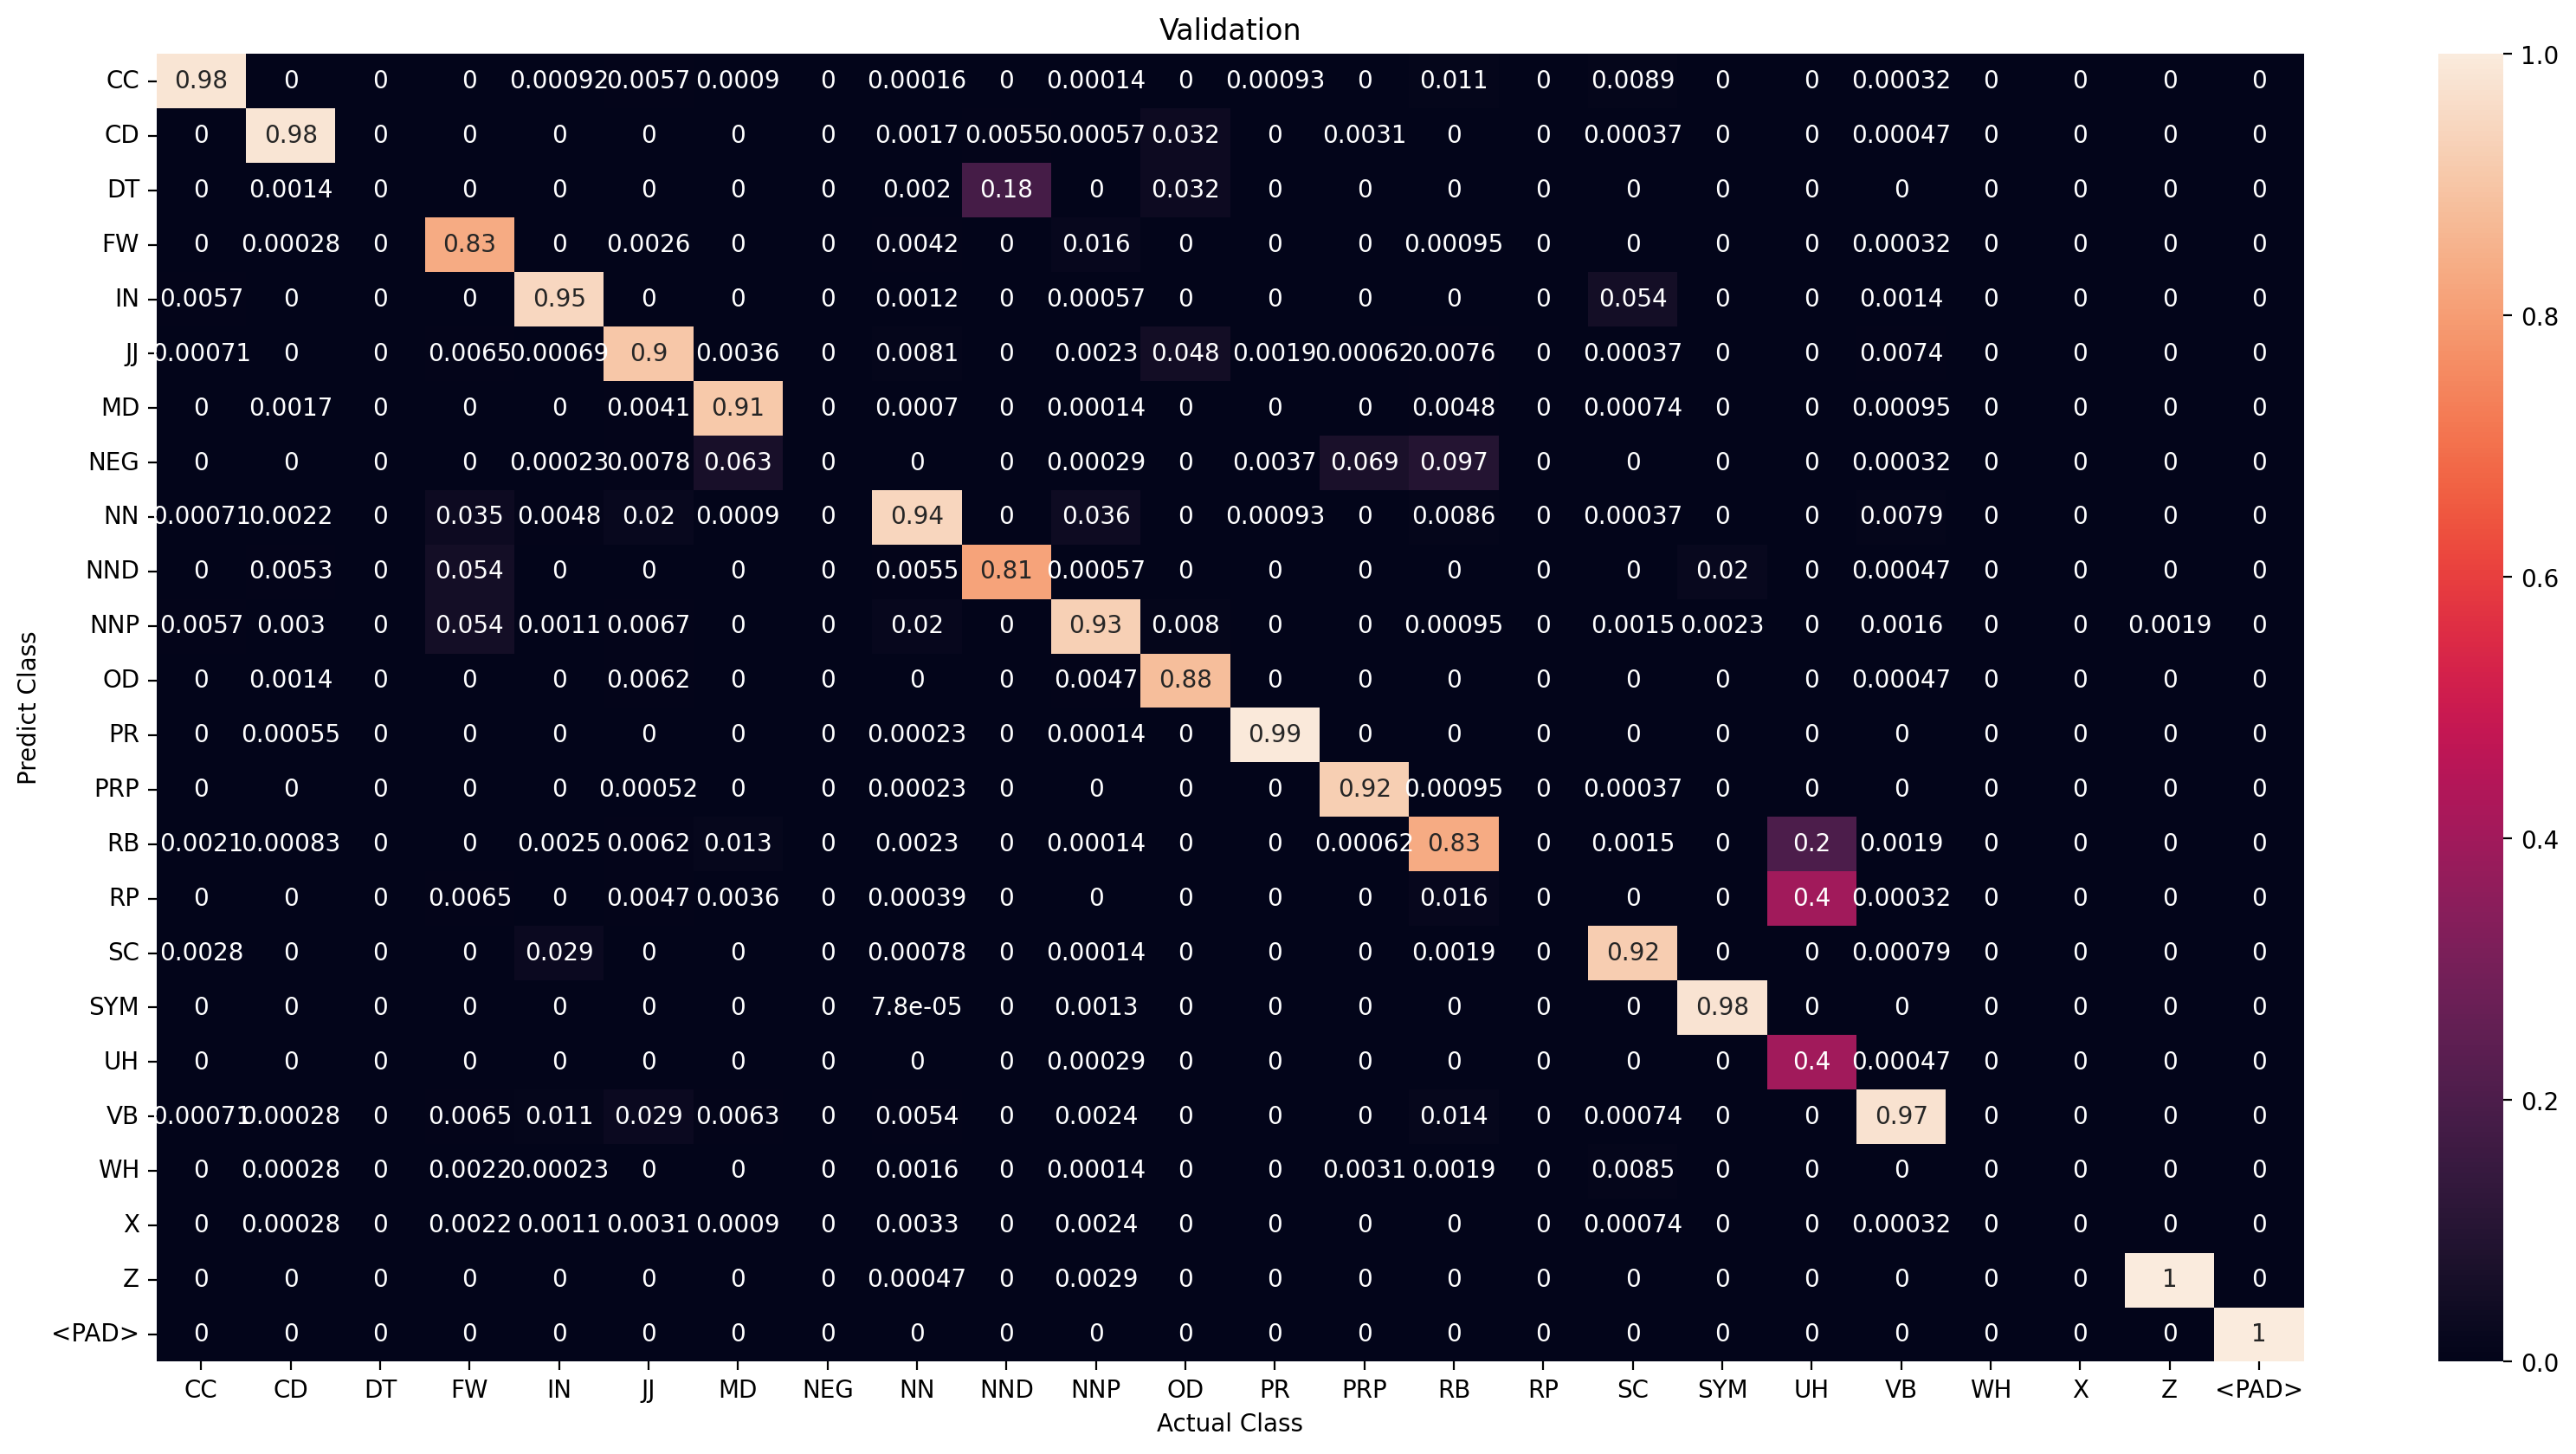

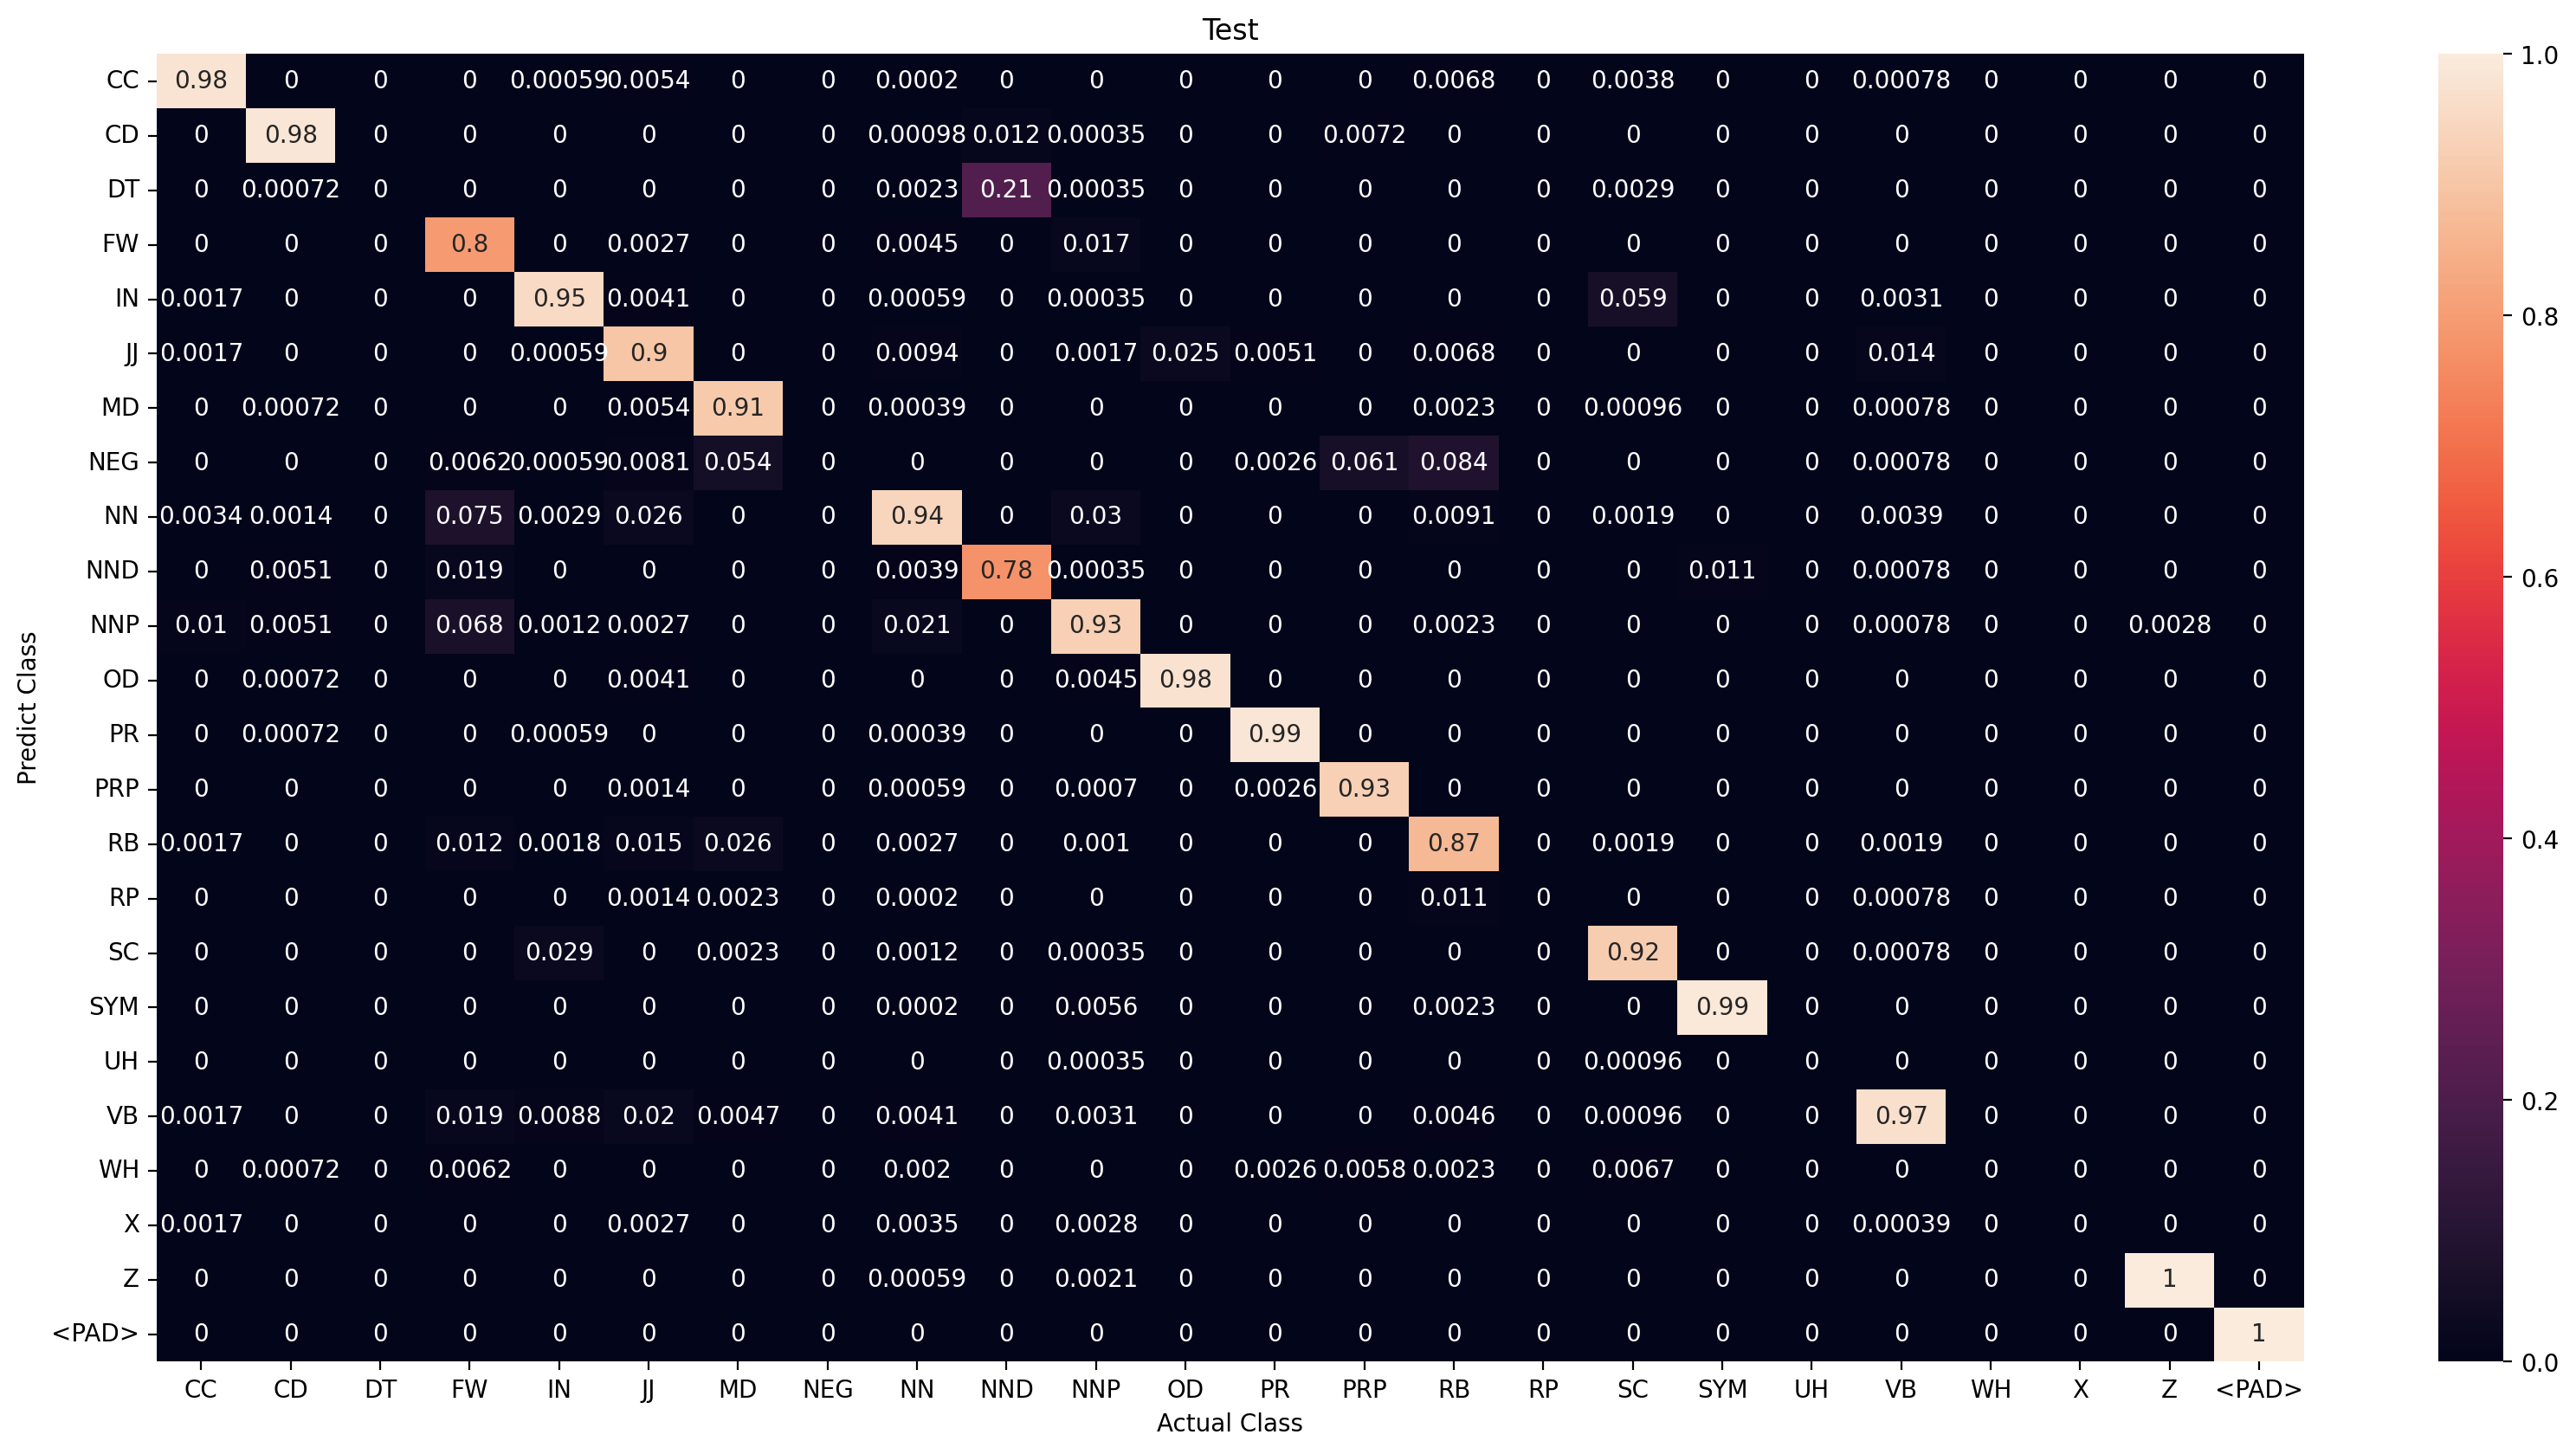

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5397   | CC    : 5279       | CC    : 118      |
| CD    : 12862  | CD    : 12772      | CD    : 90       |
| DT    : 278    | DT    : 0          | DT    : 278      |
| FW    : 1605   | FW    : 1398       | FW    : 207      |
| IN    : 15290  | IN    : 15134      | IN    : 156      |
| JJ    : 7025   | JJ    : 6577       | JJ    : 448      |
| MD    : 3798   | MD    : 3668       | MD    : 130      |
| NEG   : 1101   | NEG   : 0          | NEG   : 1101     |
| NN    : 44472  | NN    : 43997      | NN    : 475      |
| NND   : 1033   | NND   : 541        | NND   : 492      |
| NNP   : 25007  | NNP   : 24584      | NNP   : 423      |
| OD    : 519    | OD    : 359        | OD    : 160      |
| PR    : 3880   | PR    : 3848       | PR    : 32       |
| PRP   : 5449   | PRP   : 5408       | PRP   : 41       |
| RB    : 3502   | RB    : 3323       | RB    : 179      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  3, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11971
Correct prediction          : 11276
Wrong prediction            : 695
Percentage correct oov pred : 94.1943028986718

Validation
Number OOV token            : 3190
Correct prediction          : 2868
Wrong prediction            : 322
Percentage correct oov pred : 89.90595611285266

Test
Number OOV token            : 1401
Correct prediction          : 1259
Wrong prediction            : 142
Percentage correct oov pred : 89.86438258386866



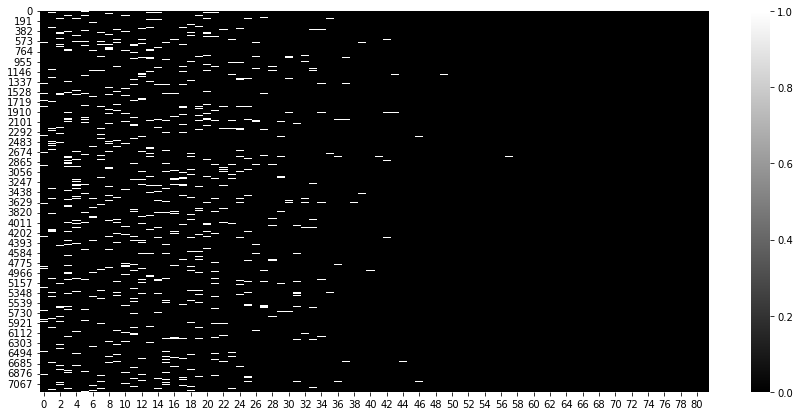

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

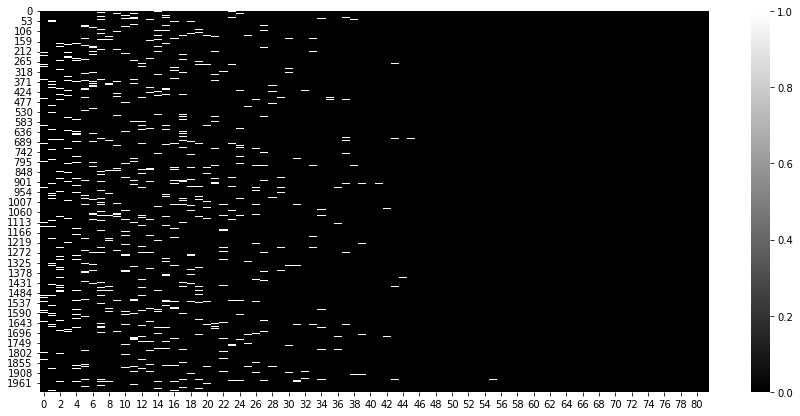

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

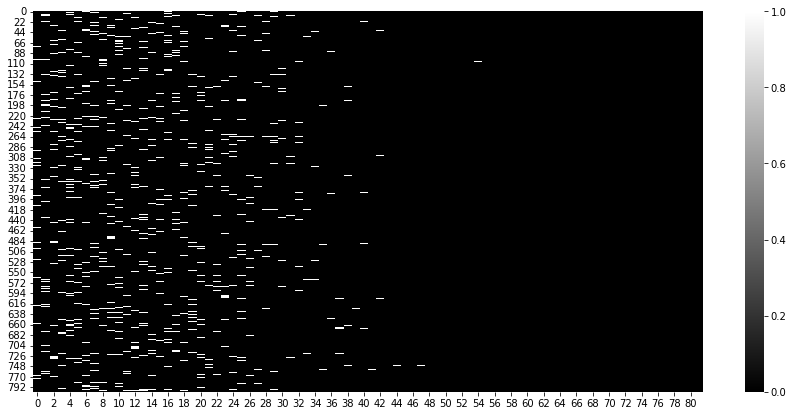

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);